**Description**: Test that priors make sense and model fitting works.

**Estimated runtime**: ~2.5 hr

In [1]:
from typing import Literal

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import xarray as xr

import utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
sns.set_theme(style="darkgrid")

# Configuration

Which number of test observations do you want to analyze?

In [3]:
num_test: Literal[200, 500] = 200

# Load data

In [4]:
accuracies_home_dir = "accuracies_from_paper"

In [5]:
num_correct_df = utils.load_all_num_correct(accuracies_home_dir, num_test)

# Simulate data

In [6]:
equation = "p(num_correct, num_test) ~ method + lm_type + (1|dataset/pair)"
id_vars = ["num_test", "pair", "lm_type", "dataset"]

In [7]:
def simulate_data(
    num_correct_df: pl.DataFrame,
    treatment_effect_prior_mean_std: tuple[float, float],
    random_seed: int = 123,
):
    # Build model to set up sampling from priors
    model = utils.create_model(
        # Picking treatment and control columns is arbitrary. Just need to tell bambi
        # what the data looks like, not what's in it. The actual data is unused
        utils.melt_num_correct(
            num_correct_df, treatment="test", control="extra", id_vars=id_vars
        ),
        equation,
        treatment_effect_prior_mean_std=treatment_effect_prior_mean_std,
    )
    model.build()

    # Fitting the model is so slow that I can only afford 1 draw
    idata_prior: az.InferenceData = model.prior_predictive(
        draws=1, random_seed=random_seed
    )
    prior: xr.DataArray = az.extract(idata_prior, group="prior_predictive")[
        "p(num_correct, num_test)"
    ]

    # Some data we'll need to populated the simulated DF
    datasets = num_correct_df["dataset"].unique(maintain_order=True)
    num_subsamples = (
        num_correct_df.group_by(["lm_type", "dataset"])
        .count()
        .select("count")
        .head(n=1)
        .item()
    )
    lm_types = num_correct_df["lm_type"].unique(maintain_order=True)

    # Inverse of melt is pivot
    # TODO: test this code for correctness
    # The number 2 in the code below refers to treatment and control
    return (
        pl.DataFrame(
            {
                "num_test": num_test,
                "pair": np.repeat(np.arange(len(num_correct_df)), 2),
                "lm_type": np.tile(
                    lm_types.to_numpy().repeat(datasets.len() * num_subsamples),
                    reps=lm_types.len(),
                ).tolist(),
                "dataset": np.tile(
                    datasets.to_numpy().repeat(num_subsamples * 2), reps=lm_types.len()
                ).tolist(),
                "method": np.tile(["control", "treatment"], reps=len(num_correct_df)),
                "num_correct": prior[:, 0].to_numpy(),
            }
        )
        .pivot(values="num_correct", index=id_vars, columns="method")
        .drop("pair")
    )

# Visually check priors

Prior predictive check = plot the distributions of the outcomes: the number of correct
predictions.

I decided to adjust some priors—$\beta$
standard deviation, $\sigma_{D}, \sigma_{V}$—from $3.5355$ to
$1$ b/c the latter results in weird, wide, basin-like outcomes. The default is also
scientifically really implausible for us.

This modification doesn't seem to affect the distribution of the posterior mean
($\beta$), i.e., it doesn't change the conclusions. It also didn't affect convergence
diagnostics—they're fine in both cases.

In [8]:
def plot_prior_predictive(treatment_effect_prior_mean_std: tuple[float, float]):
    mean, std = treatment_effect_prior_mean_std
    sns.kdeplot(
        simulate_data(num_correct_df, treatment_effect_prior_mean_std)
        .select(["control", "treatment"])
        .to_pandas()
    )
    plt.xlabel("$Y$ (number of correct predictions)")
    plt.ylabel("density")
    plt.title(f"$\\beta \\sim \\text{{Normal}}({mean}, {std})$")

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


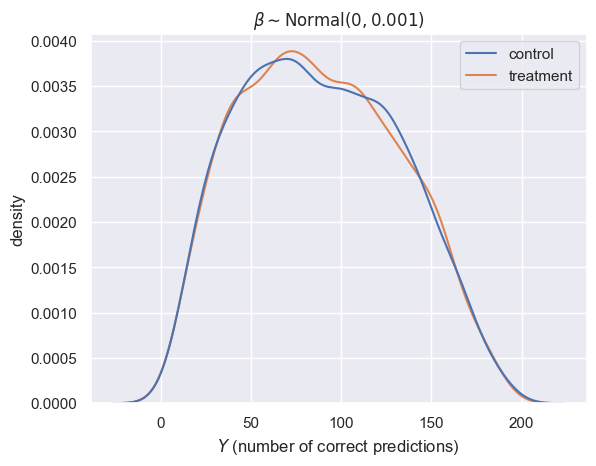

In [9]:
plot_prior_predictive(treatment_effect_prior_mean_std=(0, 0.001))

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


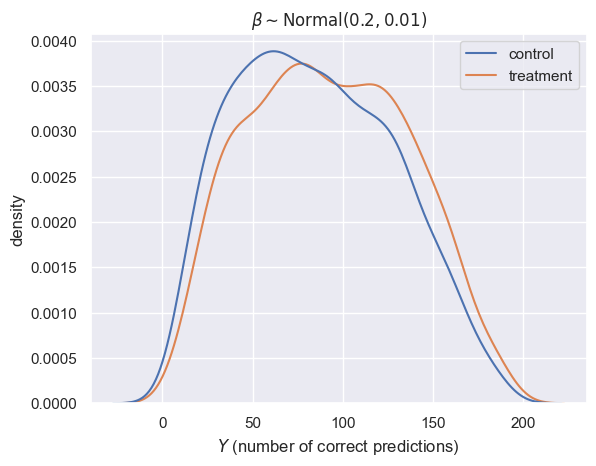

In [10]:
plot_prior_predictive(treatment_effect_prior_mean_std=(0.2, 0.01))

# Test null effect

Should not see an effect outside the range of (-0.01, 0.01) if the model makes sense and
the fit code is correct.

In [11]:
num_correct_df_simluated_null = simulate_data(
    num_correct_df, treatment_effect_prior_mean_std=(0, 0.001)
)

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3436 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[treatment],-0.001,0.005,-0.01,0.008,0.0,0.0,6741.0,2950.0,1.0


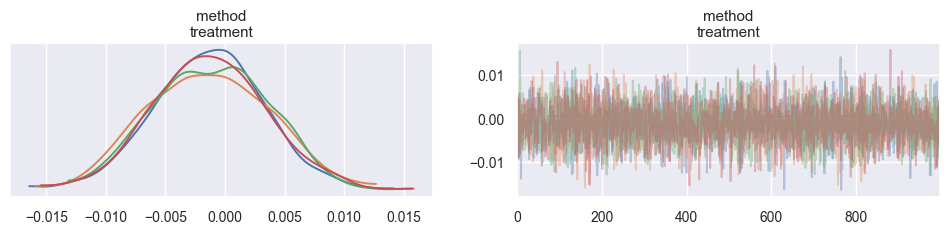

In [12]:
_, summary_null, _ = utils.stat_model(
    num_correct_df_simluated_null,
    treatment="treatment",
    control="control",
    equation=equation,
    id_vars=id_vars,
    chains=4,
)

# Test non-null effect

Should see an effect around 0.1, not including 0, if the model makes sense and the fit
code is correct.

In [13]:
num_correct_df_simluated_non_null = simulate_data(
    num_correct_df, treatment_effect_prior_mean_std=(0.1, 0.01)
)

/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Sampling: [1|dataset:pair_offset, 1|dataset:pair_sigma, 1|dataset_offset, 1|dataset_sigma, Intercept, lm_type, method, p(num_correct, num_test)]


/Users/kdubey/Envs/pretrain/lib/python3.11/site-packages/formulae/terms/call.py:108: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x) or isinstance(x, CategoricalBox):
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [Intercept, method, lm_type, 1|dataset_sigma, 1|dataset_offset, 1|dataset:pair_sigma, 1|dataset:pair_offset]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 4191 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
method[treatment],0.111,0.005,0.101,0.12,0.0,0.0,8544.0,2753.0,1.0


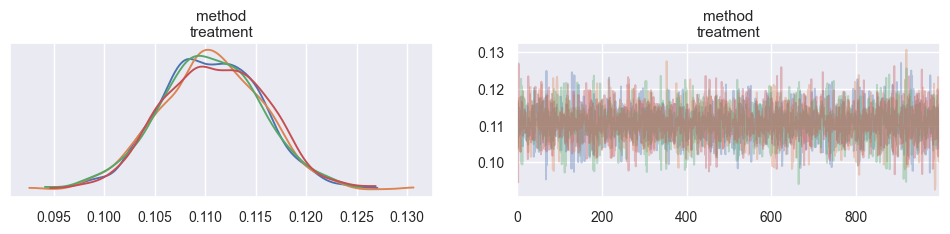

In [14]:
_, summary_non_null, _ = utils.stat_model(
    num_correct_df_simluated_non_null,
    treatment="treatment",
    control="control",
    equation=equation,
    id_vars=id_vars,
    chains=4,
)

In [15]:
summary_null.to_netcdf(filename=f"test_{num_test}_null.nc")
summary_non_null.to_netcdf(filename=f"test_{num_test}_non_null.nc")

'test_200_non_null.nc'